In [1]:
import yfinance as yf
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import openpyxl
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#%matplotlib notebook

In [12]:
SMA = 3
LMA = 15

PVTW = 10
ATRP = 14
NUMBER_OF_ROWS = 1000
MAX_HISTORY_ENTRIES = 200

In [13]:
EXCEL_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\price.xlsx"
J_FILE_PATH = r"C:\Users\David\Desktop\Pilot\END_PRODUCT\history.json"

def stp(number):
    data = {"stop_loss": number}
    print(f"New StopLoss: { number }")
    with open(r'C:\Users\David\Desktop\Pilot\END_PRODUCT\StopLoss.json', 'w') as json_file:
        json.dump(data, json_file)

def tke(number):
    data = {"take_profit": number}
    with open(r"C:\Users\David\Desktop\Pilot\END_PRODUCT\TakeProfit.json", 'w') as json_file:
        json.dump(data, json_file)

def read_values_from_j(JSON_FILE_PATH):
    with open(JSON_FILE_PATH, "r") as json_file:
        try:
            data = json.load(json_file)
            data = data[-MAX_HISTORY_ENTRIES:]
        except json.decoder.JSONDecodeError as e:
            print(f"Error decoding JSON at line {e.lineno}, column {e.colno}: {e.msg}")
            raise

    return data

def update_excel_and_save_to_j(data):
    try:
        workbook = openpyxl.load_workbook(EXCEL_FILE_PATH)
        sheet = workbook.active
        sheet.delete_rows(1, sheet.max_row)
        for item in data:
            next_row = sheet.max_row + 1
            sheet.cell(row=next_row, column=1, value=item["timestamp"])
            sheet.cell(row=next_row, column=2, value=item["price"])
        workbook.save(EXCEL_FILE_PATH)
    except FileNotFoundError:
        workbook = openpyxl.Workbook()

def tp_json():
    try:
        with open(r'C:\Users\David\Desktop\Pilot\END_PRODUCT\TakeProfit.json', 'r') as json_file:
            data = json.load(json_file)
            takeprofit = data.get("take_profit")
            return takeprofit
    except FileNotFoundError:
        print("TakeProfit.json not found. Returning None.")
        return None

def sp_json():
    try:
        with open(r'C:\Users\David\Desktop\Pilot\END_PRODUCT\StopLoss.json', 'r') as json_file:
            data = json.load(json_file)
            stoploss = data.get("stop_loss")
            return stoploss
    except FileNotFoundError:
        print("StopLoss.json not found. Returning None.")
        return None

In [14]:
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    j_data = read_values_from_j(J_FILE_PATH)
    update_excel_and_save_to_j(j_data)

    df = pd.read_excel(EXCEL_FILE_PATH, names=['Date', 'Close'])

In [15]:
#BEST SETTINGS FOR TESLA AND LIKESO VOLATILITY
df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()
df['SMAvLMA'] = np.where(df['SMA'] > df['LMA'], 1, 0)
df['ClosevMA20'] = np.where(df['Close'] > df['SMA'], 1, 0)
df['Conclusion'] = np.where((df['SMAvLMA'] >= 1) & (df['ClosevMA20'] >= 1), 1, 0)
df['MACD'] = df['SMA'] - df['LMA']
df['SL'] = df['MACD'].rolling(window=9, min_periods=1).mean()
df['High'] = df['Close'].shift(1).cummax()  
df['Low'] = df['Close'].shift(1).cummin()

df['TR1'] = df['High'] - df['Low']
df['TR2'] = abs(df['High'] - df['Close'].shift(1))
df['TR3'] = abs(df['Low'] - df['Close'].shift(1))
df['TrueRange'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
df['ATR'] = df['TrueRange'].ewm(span=atr_period, adjust=False).mean()

#TSLA best: 0.08(SL), 0.12(TP)


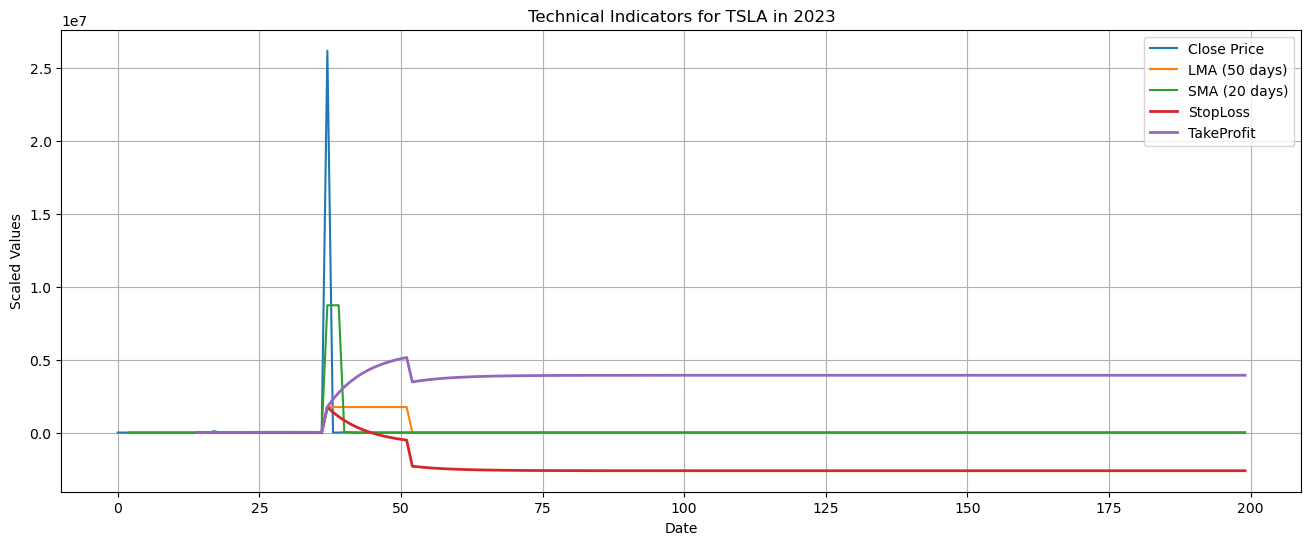

In [16]:
stop_loss_multiplier = 0.1
take_profit_multiplier = 0.15

df['StopLoss'] = df['LMA'] - stop_loss_multiplier * df['ATR']
df['TakeProfit'] = df['LMA'] + take_profit_multiplier * df['ATR']

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )

plt.plot(df.index, df['LMA'], label='LMA (50 days)')
plt.plot(df.index, df['SMA'], label='SMA (20 days)' )

plt.plot(df.index, df['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(df.index, df['TakeProfit'], label='TakeProfit', linewidth=2)
'''
# Add vertical gridlines
for date in sma_lma_intersection:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

for date in macd_sl_intersection:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.5, linewidth=0.5)
'''
plt.title('Technical Indicators for TSLA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

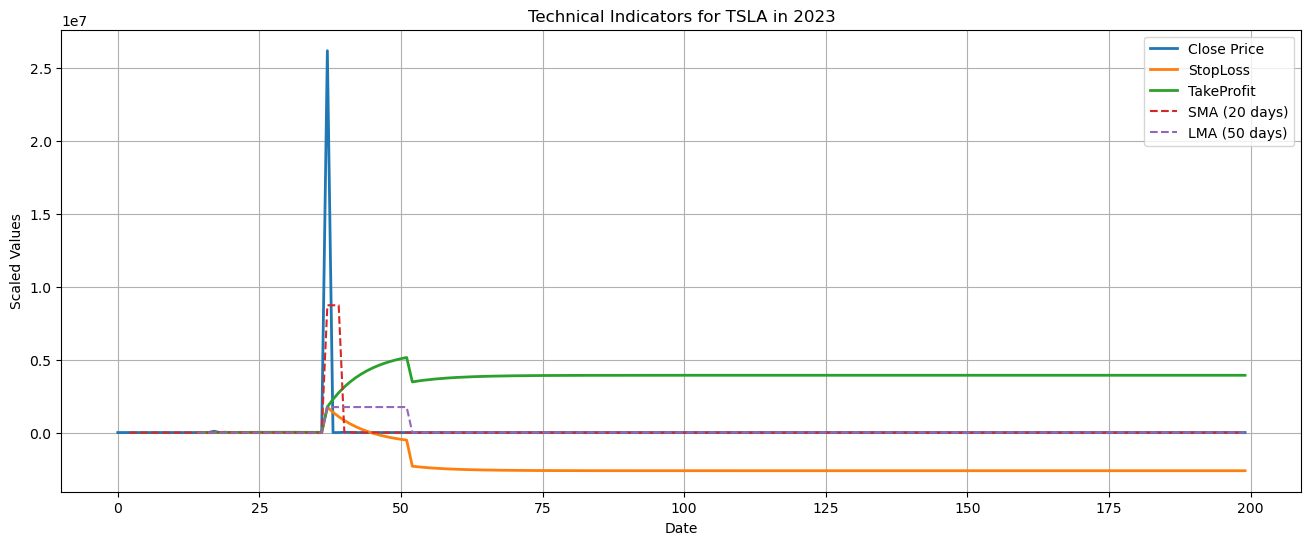

In [17]:
# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price', linewidth=2)
plt.plot(df.index, df['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(df.index, df['TakeProfit'], label='TakeProfit', linewidth=2)
plt.plot(df.index, df['SMA'], label='SMA (20 days)', linestyle='--')
plt.plot(df.index, df['LMA'], label='LMA (50 days)', linestyle='--')

plt.title('Technical Indicators for TSLA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  6 of 6 completed


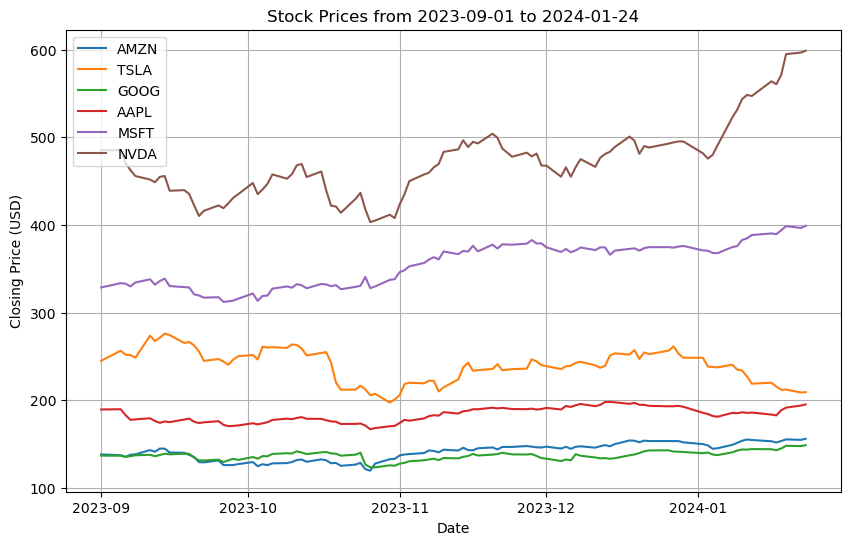

In [18]:
import yfinance as yf
import matplotlib.pyplot as plt

# Define the stock symbols
stocks = ['AMZN', 'TSLA', 'GOOG', 'AAPL', 'MSFT', 'NVDA']  # Add two stocks of your choice below $200

# Define the time period
start_date = '2023-09-01'
end_date = '2024-01-24'

# Fetch historical data
data = yf.download(stocks, start=start_date, end=end_date)

# Plot the closing prices
plt.figure(figsize=(10, 6))
for stock in stocks:
    plt.plot(data.index, data['Close'][stock], label=stock)

plt.title('Stock Prices from {} to {}'.format(start_date, end_date))
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [20]:

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
Cell In[59], line 12
      9 nvda['Low'] = nvda['NVDA'].shift(1).cummin()
     11 nvda['TR1'] = nvda['High'] - nvda['Low']
---> 12 nvda['TR2'] = abs(nvda['High'] - ['NVDA'].shift(1))
     13 nvda['TR3'] = abs(nvda['Low'] - nvda['NVDA'].shift(1))
     14 nvda['TrueRange'] = nvda[['TR1', 'TR2', 'TR3']].max(axis=1)

AttributeError: 'list' object has no attribute 'shift'

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

In [ ]:

nvda['Close'] = nvda['NVDA']

nvda['SMA'] = nvda['Close'].rolling(SMA).mean()
nvda['LMA'] = nvda['Close'].rolling(LMA).mean()
nvda['SMAvLMA'] = np.where(nvda['SMA'] > nvda['LMA'], 1, 0)
nvda['ClosevMA20'] = np.where(nvda['Close'] > nvda['SMA'], 1, 0)
nvda['Conclusion'] = np.where((nvda['SMAvLMA'] >= 1) & (nvda['ClosevMA20'] >= 1), 1, 0)
nvda['MACD'] = nvda['SMA'] - nvda['LMA']
nvda['SL'] = nvda['MACD'].rolling(window=9, min_periods=1).mean()
nvda['High'] = nvda['Close'].shift(1).cummax()  
nvda['Low'] = nvda['Close'].shift(1).cummin()

nvda['TR1'] = nvda['High'] - nvda['Low']
nvda['TR2'] = abs(nvda['High'] - nvda['Close'].shift(1))
nvda['TR3'] = abs(nvda['Low'] - nvda['Close'].shift(1))
nvda['TrueRange'] = nvda[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
nvda['ATR'] = nvda['TrueRange'].ewm(span=atr_period, adjust=False).mean()

stop_loss_multiplier = 0.08
take_profit_multiplier = 0.12

nvda['StopLoss'] = nvda['LMA'] - stop_loss_multiplier * nvda['ATR']
nvda['TakeProfit'] = nvda['LMA'] + take_profit_multiplier * nvda['ATR']


In [ ]:
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    j_data = read_values_from_j(J_FILE_PATH)
    update_excel_and_save_to_j(j_data)

    df = pd.read_excel(EXCEL_FILE_PATH, names=['Date', 'Close'])


In [ ]:
nvda['SMA'] = nvda['NVDA'].rolling(SMA).mean()
nvda['LMA'] = nvda['NVDA'].rolling(LMA).mean()
nvda['SMAvLMA'] = np.where(nvda['SMA'] > nvda['LMA'], 1, 0)
nvda['ClosevMA20'] = np.where(nvda['NVDA'] > nvda['SMA'], 1, 0)
nvda['Conclusion'] = np.where((nvda['SMAvLMA'] >= 1) & (nvda['ClosevMA20'] >= 1), 1, 0)
nvda['MACD'] = nvda['SMA'] - nvda['LMA']
nvda['SL'] = nvda['MACD'].rolling(window=9, min_periods=1).mean()
nvda['High'] = nvda['NVDA'].shift(1).cummax()  
nvda['Low'] = nvda['NVDA'].shift(1).cummin()

nvda['TR1'] = nvda['High'] - nvda['Low']
nvda['TR2'] = abs(nvda['High'] - nvda['NVDA'].shift(1))  # Fix the typo here
nvda['TR3'] = abs(nvda['Low'] - nvda['NVDA'].shift(1))
nvda['TrueRange'] = nvda[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
nvda['ATR'] = nvda['TrueRange'].ewm(span=atr_period, adjust=False).mean()

nvda['StopLossMultiplier'] = 0.2 * (nvda['ATR'] / nvda['NVDA'])
nvda['TakeProfitMultiplier'] = 0.3 * (nvda['ATR'] / nvda['NVDA'])

# Apply the adjusted multipliers to calculate StopLoss and TakeProfit
nvda['StopLoss'] = nvda['LMA'] - nvda['StopLossMultiplier'] * nvda['ATR']
nvda['TakeProfit'] = nvda['LMA'] + nvda['TakeProfitMultiplier'] * nvda['ATR']


In [ ]:
# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(nvda.index, nvda['Close'], label='Close Price', linewidth=2)
plt.plot(nvda.index, nvda['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(nvda.index, nvda['TakeProfit'], label='TakeProfit', linewidth=2)
plt.plot(nvda.index, nvda['SMA'], label='SMA (20 days)', linestyle='--')
plt.plot(nvda.index, nvda['LMA'], label='LMA (50 days)', linestyle='--')


plt.title('Technical Indicators for NVDA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )

In [ ]:
df['Close']

In [ ]:
stop_loss_multiplier = 0.18
take_profit_multiplier = 0.3
atr_period = 20

SMA = 2
LMA = 12

df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()

df['ATR'] = df['TrueRange'].ewm(span=atr_period, adjust=False).mean()

df['StopLoss'] = df['LMA'] - stop_loss_multiplier * df['ATR']
df['TakeProfit'] = df['LMA'] + take_profit_multiplier * df['ATR']

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )

plt.plot(df.index, df['LMA'], label='LMA (50 days)', linestyle='--')
plt.plot(df.index, df['SMA'], label='SMA (20 days)', linestyle='--' )

plt.plot(df.index, df['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(df.index, df['TakeProfit'], label='TakeProfit', linewidth=2)

'''
# Add vertical gridlines
for date in sma_lma_intersection:
    plt.axvline(x=date, color='gray', linestyle='--', alpha=0.5, linewidth=0.5)

for date in macd_sl_intersection:
    plt.axvline(x=date, color='orange', linestyle='--', alpha=0.5, linewidth=0.5)
'''
plt.title('Technical Indicators for TSLA in 2023')
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(16, 6))
atr_normalized = df['ATR'] / df['Close'].max()  
plt.plot(df.index, atr_normalized, label='ATR', linewidth=2)
plt.show()

In [ ]:
import yfinance as yf
import pandas as pd

# Replace 'AAPL' with the stock or index you are interested in
symbol = 'AAPL'

# Download historical data
data = yf.download(symbol, start='2023-01-01', end='2024-01-01')

# Calculate daily returns
data['DailyReturns'] = data['Adj Close'].pct_change()

# Calculate historical volatility (annualized)
hd = data['historical_volatility'] = data['DailyReturns'].std() * (252 ** 0.5)  # Assuming 252 trading days in a year


# Display the result
print(f"Symbol: {symbol}")
print(f"Historical Volatility: {hd:.4%}")


In [ ]:
df['Vol'] = ((df['Close'].rolling(20).max() - df['Close'].rolling(20).min()) / df['Close'].rolling(20).min()) * 100

stop_loss_multiplier = df['Vol'] / 5
take_profit_multiplier = df['Vol'] / 2.5
atr_period = 20

SMA = 3
LMA = 17

df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()

df['ATR'] = df['TrueRange'].ewm(span=atr_period, adjust=False).mean()

df['StopLoss'] = df['LMA'] - stop_loss_multiplier * df['ATR']
df['TakeProfit'] = df['LMA'] + take_profit_multiplier * df['ATR']

# Plot the data
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Close Price' )

plt.plot(df.index, df['LMA'], label='LMA (50 days)')
plt.plot(df.index, df['SMA'], label='SMA (20 days)' )

plt.plot(df.index, df['StopLoss'], label='StopLoss', linewidth=2)
plt.plot(df.index, df['TakeProfit'], label='TakeProfit', linewidth=2)

plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['Vol'] / 4

In [ ]:
df['LMA-SMA'] = df['SMA'] - df['LMA']
df['Vol1'] = df['Vol'] = ((df['LMA-SMA'].rolling(20).max() - df['LMA-SMA'].rolling(20).min()) / df['LMA-SMA'].rolling(20).min()) * 100

In [ ]:
df['Vol1']

In [ ]:
df['MAX'] = (df['Close'].rolling(25)).max()- df['Close']
df['MIN'] = (df['Close'].rolling(25)).min()- df['Close']

In [ ]:
df['MAX']

In [ ]:
df['Close']

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['MAX'], label='MAX', linewidth=2, color='green')
plt.plot(df.index, df['MIN']*-1, label='MIN', linewidth=2, color='red')
plt.title('Rolling Minimum Values')
plt.xlabel('Date')
plt.ylabel('Minimum Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Assuming you have df with the required columns ('Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'Conclusion', 'MACD', 'SL', 'ATR')
# Fill missing values or drop them
df.dropna(inplace=True)

# Features and target
features = df[['Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR']]
target = df['Close'].shift(-1)  # Predicting the next day's closing price

# Normalize features
scaler = MinMaxScaler()
features_normalized = scaler.fit_transform(features)
target_normalized = scaler.fit_transform(target.values.reshape(-1, 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)

# Build the neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Mean Squared Error on Test Data: {loss}')

# Make predictions
predictions = model.predict(X_test)

# De-normalize predictions
predictions_denormalized = scaler.inverse_transform(predictions)

# Evaluate performance (you can use more sophisticated metrics)
mse = np.mean(np.square(predictions_denormalized - df['Close'].iloc[-len(X_test):].values))
print(f'Mean Squared Error on Test Data (Denormalized): {mse}')

# Plot predictions vs actual prices
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(df.index[-len(X_test):], df['Close'].iloc[-len(X_test):].values, label='Actual Prices', linewidth=2)
plt.plot(df.index[-len(X_test):], predictions_denormalized, label='Predicted Prices', linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

j_data = read_values_from_j(J_FILE_PATH)
update_excel_and_save_to_j(j_data)

df = pd.read_excel(EXCEL_FILE_PATH, names=['Date', 'Close'])

df['SMA'] = df['Close'].rolling(SMA).mean()
df['LMA'] = df['Close'].rolling(LMA).mean()
df['SMAvLMA'] = np.where(df['SMA'] > df['LMA'], 1, 0)
df['ClosevMA20'] = np.where(df['Close'] > df['SMA'], 1, 0)
df['Conclusion'] = np.where((df['SMAvLMA'] >= 1) & (df['ClosevMA20'] >= 1), 1, 0)
df['MACD'] = df['SMA'] - df['LMA']
df['SL'] = df['MACD'].rolling(window=9, min_periods=1).mean()
df['High'] = df['Close'].shift(1).cummax()  
df['Low'] = df['Close'].shift(1).cummin()

df['TR1'] = df['High'] - df['Low']
df['TR2'] = abs(df['High'] - df['Close'].shift(1))
df['TR3'] = abs(df['Low'] - df['Close'].shift(1))
df['TrueRange'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

atr_period = 14
df['ATR'] = df['TrueRange'].ewm(span=atr_period, adjust=False).mean()

In [11]:
def train_model_until_accuracy(df, target_column='Close', accuracy_threshold=0.95, max_epochs=100):
    # Assuming you have df with the required columns ('Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR')
    # Fill missing values or drop them
    df.dropna(inplace=True)

    # Features and target
    features = df[['Close', 'SMA', 'LMA', 'SMAvLMA', 'ClosevMA20', 'MACD', 'SL', 'ATR']]
    target = df[target_column].shift(-1)  # Predicting the next day's closing price

    # Normalize features
    scaler = MinMaxScaler()
    features_normalized = scaler.fit_transform(features)
    target_normalized = scaler.fit_transform(target.values.reshape(-1, 1))

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_normalized, target_normalized, test_size=0.2, random_state=42)

    # Build the neural network
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(features.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    epoch = 0
    while epoch < max_epochs:
        # Train the model for one epoch
        model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose=0)

        # Evaluate the model on the test set
        loss = model.evaluate(X_test, y_test, verbose=0)

        # Make predictions
        predictions = model.predict(X_test)

        # De-normalize predictions
        predictions_denormalized = scaler.inverse_transform(predictions)

        # Calculate accuracy
        accuracy = np.mean(np.square(predictions_denormalized - df[target_column].iloc[-len(X_test):].values))

        print(f'Epoch: {epoch + 1}, Loss: {loss}, Accuracy: {accuracy}')

        # Check if accuracy threshold is reached
        if accuracy >= accuracy_threshold:
            print(f'Training stopped. Desired accuracy ({accuracy_threshold * 100}%) reached.')
            break

        epoch += 1

    return model

# Example usage
trained_model = train_model_until_accuracy(df)

2/2 [==============================] - 0s 6ms/step
Epoch: 1, Loss: 0.0004571290919557214, Accuracy: 312775669959.76794
Training stopped. Desired accuracy (95.0%) reached.
